## Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
import string

## Load and Explore the Dataset

In [38]:
# Load the dataset
df = pd.read_csv('./Data/spam.csv', encoding='latin-1')

# Drop unnecessary columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Explore the dataset
print(df.head())
print(df.info())
print(df['label'].value_counts())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


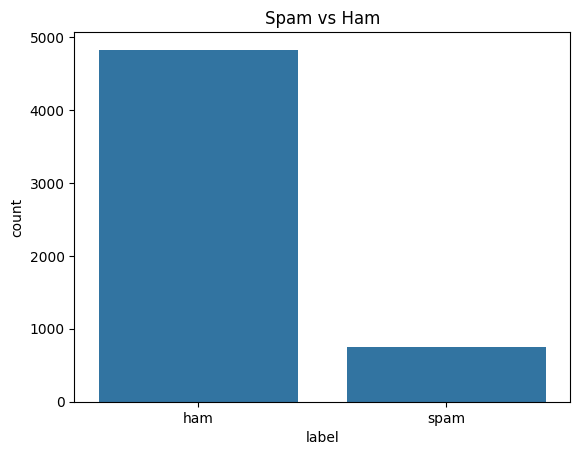

In [39]:
# Visualize the distribution of spam vs ham
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham')
plt.show()

## Preprocess the Text Data

In [40]:
# Download stopwords
nltk.download('stopwords')

# Define a function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Apply preprocessing to the 'message' column
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Check the cleaned data
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  label                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


## Feature Extraction

In [41]:
# Convert text to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_message']).toarray()

# Target variable
y = df['label'].map({'ham': 0, 'spam': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyperparameter Tuning using GridSearchCV

In [42]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 2.0


## Train the model with the best hyperparameters

In [43]:
# Train the model with the best hyperparameter
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


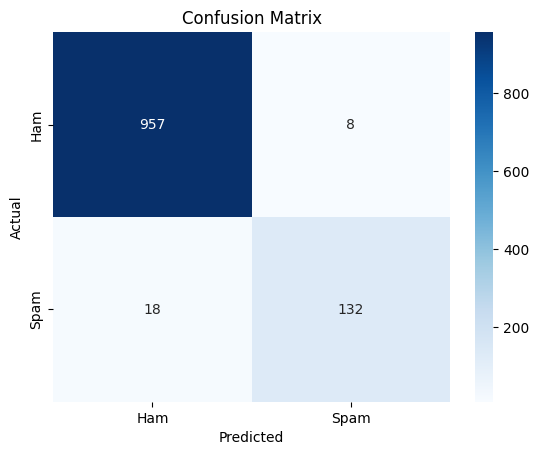

In [45]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Classification report
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       965
        Spam       0.94      0.88      0.91       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [47]:
# Cross-validation to check for overfitting
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores):.2f}')

Cross-validation scores: [0.98206278 0.98206278 0.97576302 0.98025135 0.97307002]
Mean cross-validation score: 0.98


In [48]:
# Hypothesis Testing (Comparing with a baseline model)
from sklearn.dummy import DummyClassifier

# Baseline model (always predicts the majority class)
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline accuracy: {baseline_accuracy:.2f}')

Baseline accuracy: 0.87


In [49]:
# Perform a statistical test to compare the models
from scipy.stats import ttest_ind

# Compare the accuracy of the best model and the baseline model
best_model_accuracy = accuracy_score(y_test, y_pred)
t_stat, p_value = ttest_ind([best_model_accuracy] * len(y_test), [baseline_accuracy] * len(y_test))
print(f'T-statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
    print('The best model performs significantly better than the baseline model.')
else:
    print('The best model does not perform significantly better than the baseline model.')

T-statistic: inf, P-value: 0.0
The best model performs significantly better than the baseline model.


c:\Users\SIAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## Save the Model and Vectorizer

In [54]:
import joblib

# Save the best model
joblib.dump(best_model, 'spam_classifier_model.pkl')

# Save the vectorizer
joblib.dump(vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

## Test the Model on New Data

In [63]:
# Define new data (example messages)
new_data = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.",  # Likely spam
    "Hey, are we still meeting for lunch today?",  # Likely ham
    "URGENT: Your bank account has been compromised. Click here to secure your account.",  # Likely spam
    "Can you send me the report by EOD?",  # Likely ham
    "Get a free iPhone today! Limited time offer. Click now!"  # Likely spam
]

# Preprocess the new data
new_data_cleaned = [preprocess_text(message) for message in new_data]

# Transform the new data using the same CountVectorizer
X_new = vectorizer.transform(new_data_cleaned).toarray()

# Make predictions
new_predictions = best_model.predict(X_new)


# Map predictions to labels
predicted_labels = ['spam' if pred == 1 else 'ham' for pred in new_predictions]

# Display results
for message, label in zip(new_data, predicted_labels):
    print(f"Message: {message}")
    print(f"Predicted Label: {label}")
    print("-" * 50)

Message: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
Predicted Label: spam
--------------------------------------------------
Message: Hey, are we still meeting for lunch today?
Predicted Label: ham
--------------------------------------------------
Message: URGENT: Your bank account has been compromised. Click here to secure your account.
Predicted Label: spam
--------------------------------------------------
Message: Can you send me the report by EOD?
Predicted Label: ham
--------------------------------------------------
Message: Get a free iPhone today! Limited time offer. Click now!
Predicted Label: ham
--------------------------------------------------
